<a href="https://colab.research.google.com/github/intimanjunath/Clustering/blob/main/f_clustering_of_timeseries_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries
!pip install tslearn scikit-learn numpy pandas matplotlib seaborn torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 16.3 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tslearn.utils import to_time_series_dataset
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

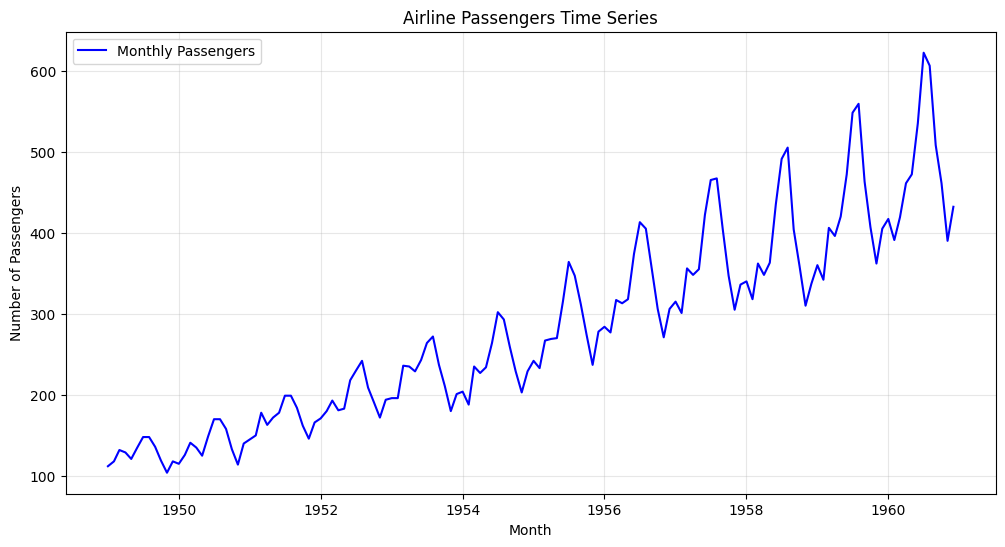

In [7]:
def load_time_series_dataset():
    """Load a real-world time series dataset."""
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url)
    df["Month"] = pd.to_datetime(df["Month"])
    df.set_index("Month", inplace=True)
    return df

# Load the dataset
time_series_df = load_time_series_dataset()

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(time_series_df.index, time_series_df["Passengers"], label="Monthly Passengers", color="blue")
plt.title("Airline Passengers Time Series")
plt.xlabel("Month")
plt.ylabel("Number of Passengers")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

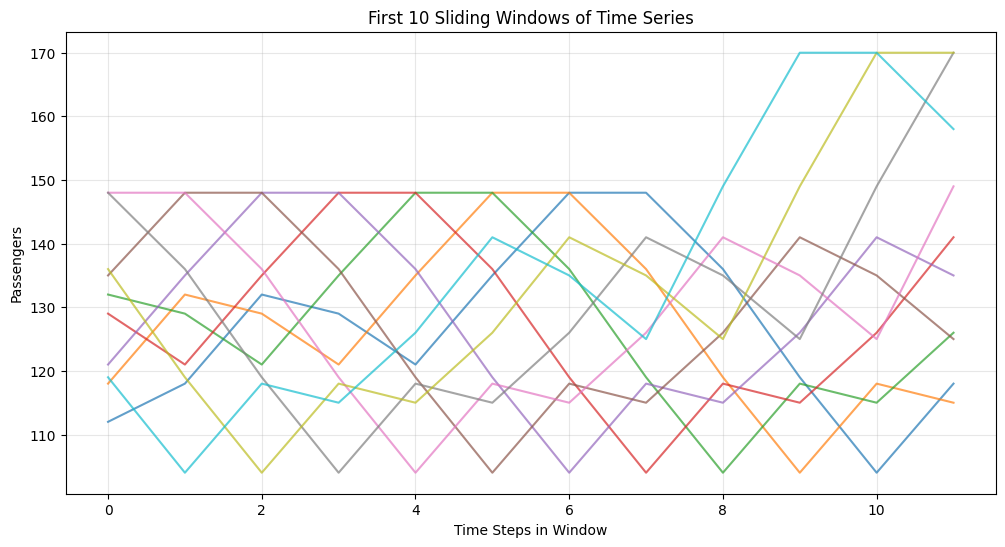

In [8]:
def preprocess_time_series(data, window_size=12):
    """Convert the time series into sliding windows."""
    n_samples = len(data) - window_size + 1
    sliding_windows = np.array([data[i : i + window_size] for i in range(n_samples)])
    scaler = StandardScaler()
    scaled_windows = scaler.fit_transform(sliding_windows.reshape(-1, window_size))
    return scaled_windows, sliding_windows

# Define window size and preprocess
window_size = 12
scaled_data, original_windows = preprocess_time_series(time_series_df["Passengers"].values, window_size)

# Visualize the sliding windows
plt.figure(figsize=(12, 6))
for i in range(10):  # Plot the first 10 windows
    plt.plot(original_windows[i], alpha=0.7)
plt.title("First 10 Sliding Windows of Time Series")
plt.xlabel("Time Steps in Window")
plt.ylabel("Passengers")
plt.grid(alpha=0.3)
plt.show()

In [9]:
class PretrainedTimeSeriesEncoder(nn.Module):
    """Simulates a pretrained model for feature extraction."""
    def __init__(self, input_dim, feature_dim=64):
        super(PretrainedTimeSeriesEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, feature_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.mean(x, dim=-1)  # Global Average Pooling
        x = self.fc(x)
        return x

# Initialize the model
input_dim = 1
feature_model = PretrainedTimeSeriesEncoder(input_dim=input_dim)

In [10]:
# Extract features
def extract_features(data, model):
    """Extract features from time series windows."""
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    features = model(data_tensor).detach().numpy()
    return features

extracted_features = extract_features(scaled_data, feature_model)

# Perform clustering
def perform_clustering(features, n_clusters=3):
    """Perform clustering using KMeans."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans

n_clusters = 3
cluster_labels, kmeans_model = perform_clustering(extracted_features, n_clusters)

Silhouette Score: 0.551


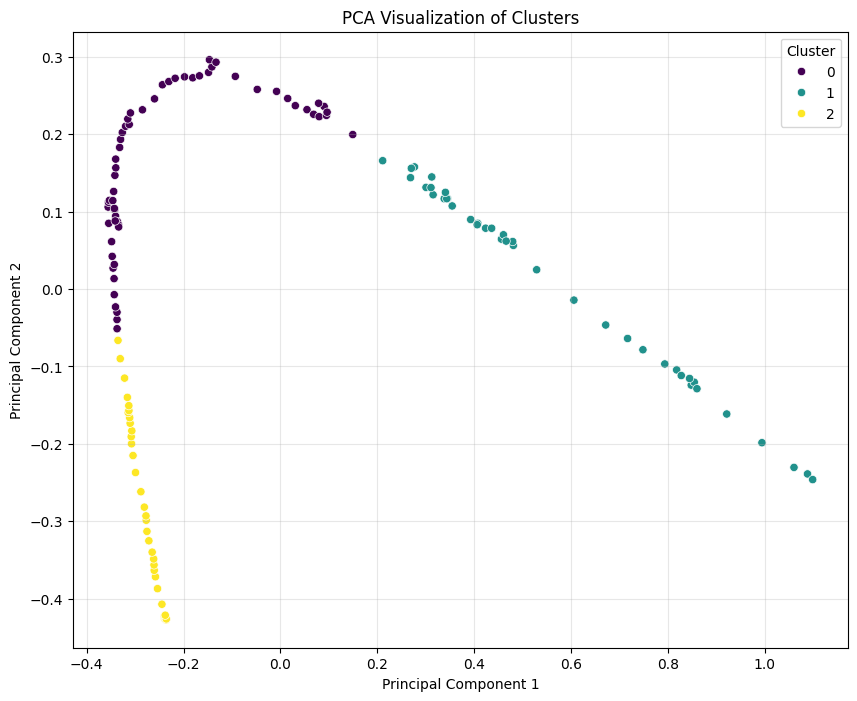

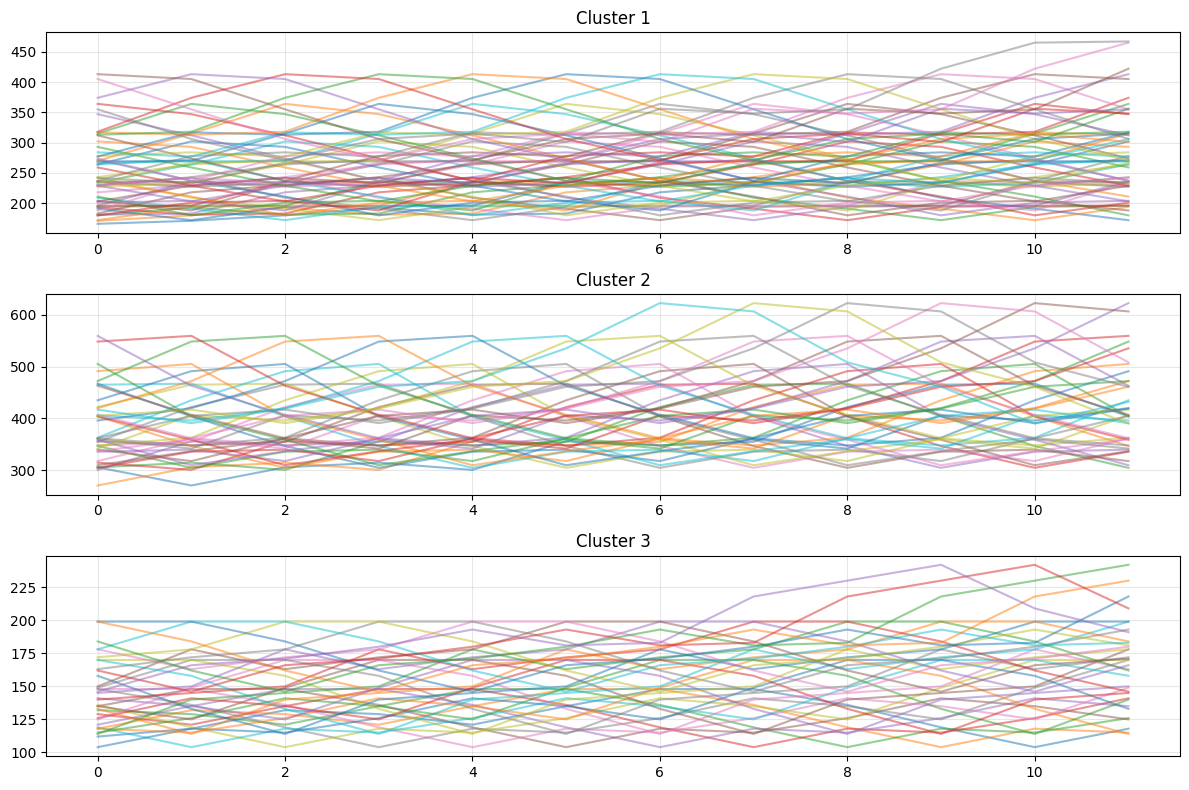

<ipython-input-11-15831721c041>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


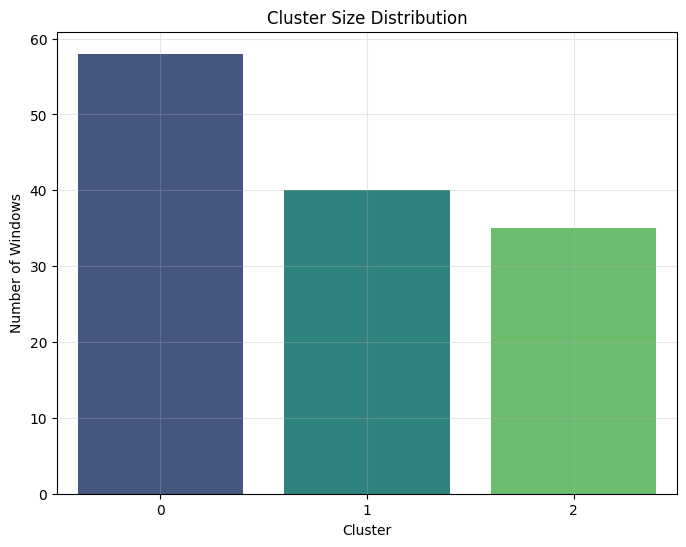

In [11]:
# Evaluate clustering using silhouette score
silhouette_avg = silhouette_score(extracted_features, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")

# PCA visualization of clusters
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(extracted_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_features[:, 0], y=reduced_features[:, 1], hue=cluster_labels, palette="viridis"
)
plt.title("PCA Visualization of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.show()

# Visualize the clustered time series windows
def visualize_clusters(windows, labels, n_clusters):
    """Visualize clustered time series windows."""
    plt.figure(figsize=(12, 8))
    for cluster in range(n_clusters):
        plt.subplot(n_clusters, 1, cluster + 1)
        cluster_windows = windows[labels == cluster]
        for series in cluster_windows:
            plt.plot(series, alpha=0.5)
        plt.title(f"Cluster {cluster + 1}")
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the clusters
visualize_clusters(original_windows, cluster_labels, n_clusters)

# Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Windows")
plt.grid(alpha=0.3)
plt.show()

In [14]:
# Predict future cluster transitions
def predict_future_clusters(current_window, model, kmeans):
    """Predict the cluster for a future time series window."""
    # Ensure the input is in the correct shape: [batch_size, channels, time_steps]
    current_window = torch.tensor(current_window, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    features = model(current_window).detach().numpy()
    predicted_cluster = kmeans.predict(features)[0]
    return predicted_cluster

# Predict the cluster for the last window in the series
last_window = scaled_data[-1]  # Shape: [12]
predicted_cluster = predict_future_clusters(last_window, feature_model, kmeans_model)
print(f"The predicted cluster for the next window: {predicted_cluster}")

The predicted cluster for the next window: 1


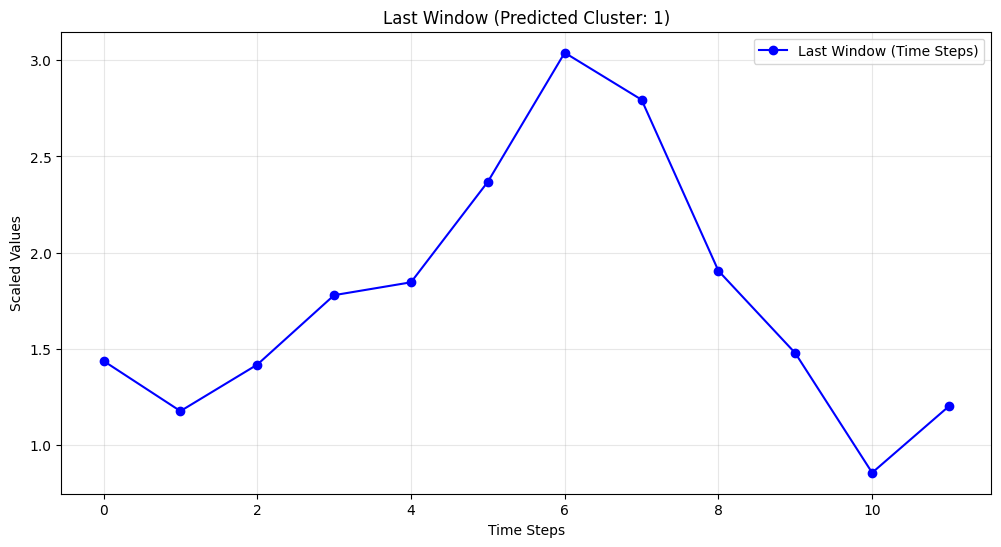

In [15]:
# Visualize the last window and its predicted cluster
plt.figure(figsize=(12, 6))
plt.plot(last_window, label="Last Window (Time Steps)", color="blue", marker="o")
plt.title(f"Last Window (Predicted Cluster: {predicted_cluster})")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

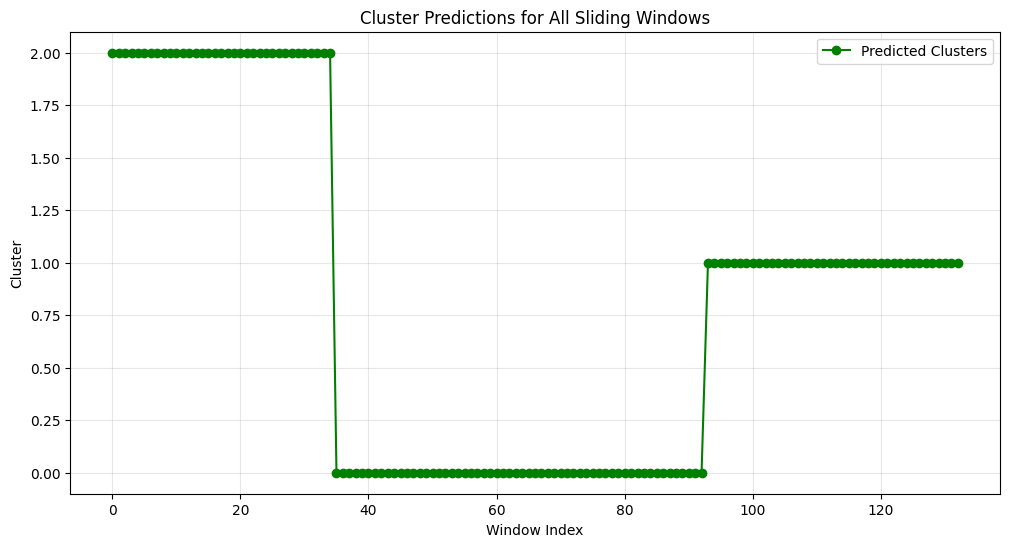

In [16]:
# Predict clusters for all windows
predicted_clusters = []
for window in scaled_data:
    cluster = predict_future_clusters(window, feature_model, kmeans_model)
    predicted_clusters.append(cluster)

# Plot cluster predictions over time
plt.figure(figsize=(12, 6))
plt.plot(predicted_clusters, label="Predicted Clusters", marker="o", linestyle="-", color="green")
plt.title("Cluster Predictions for All Sliding Windows")
plt.xlabel("Window Index")
plt.ylabel("Cluster")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

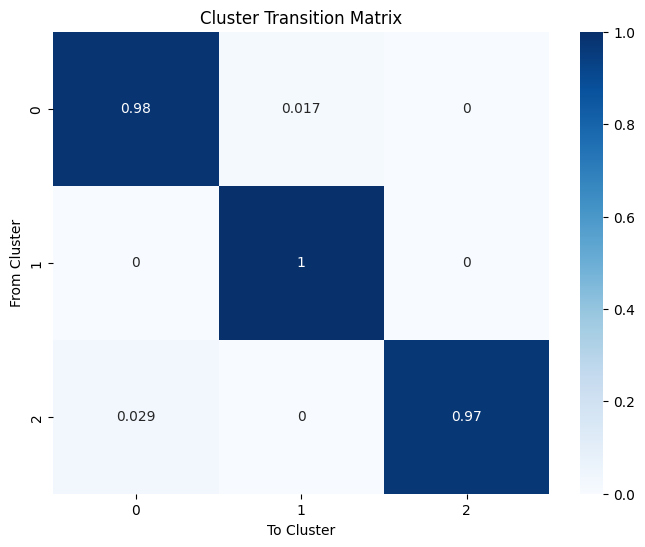

In [17]:
# Compute transition matrix
from collections import Counter

transitions = [(predicted_clusters[i], predicted_clusters[i + 1]) for i in range(len(predicted_clusters) - 1)]
transition_counts = Counter(transitions)

# Create a transition matrix
transition_matrix = np.zeros((n_clusters, n_clusters))
for (from_cluster, to_cluster), count in transition_counts.items():
    transition_matrix[from_cluster, to_cluster] = count

# Normalize the transition matrix
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Visualize the transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, cmap="Blues", xticklabels=range(n_clusters), yticklabels=range(n_clusters))
plt.title("Cluster Transition Matrix")
plt.xlabel("To Cluster")
plt.ylabel("From Cluster")
plt.show()

In [18]:
# Forecast clusters for the next N windows
def forecast_clusters(initial_window, model, kmeans, n_forecast=5):
    """Forecast clusters for the next N windows."""
    current_window = initial_window.copy()
    forecasted_clusters = []

    for _ in range(n_forecast):
        # Predict the cluster for the current window
        predicted_cluster = predict_future_clusters(current_window, model, kmeans)
        forecasted_clusters.append(predicted_cluster)

        # Simulate future data by shifting the window (dummy values for now)
        future_value = np.random.normal(loc=0, scale=1)  # Replace with a realistic future value generator
        current_window = np.roll(current_window, -1)
        current_window[-1] = future_value

    return forecasted_clusters

# Forecast the next 5 clusters
forecasted_clusters = forecast_clusters(last_window, feature_model, kmeans_model, n_forecast=5)
print(f"Forecasted Clusters for the Next 5 Windows: {forecasted_clusters}")

Forecasted Clusters for the Next 5 Windows: [1, 1, 1, 1, 1]


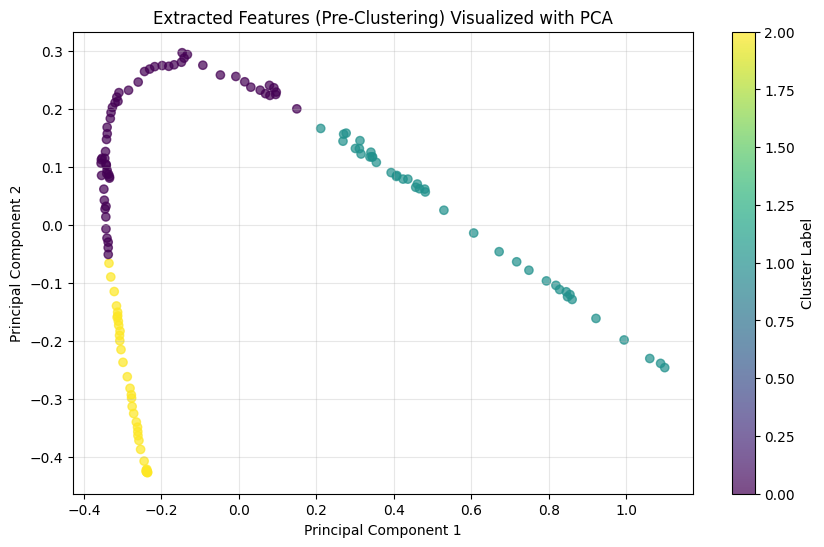

In [19]:
# Visualize extracted features using PCA
pca_features = PCA(n_components=2).fit_transform(extracted_features)

plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.7, cmap="viridis", c=cluster_labels)
plt.title("Extracted Features (Pre-Clustering) Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.grid(alpha=0.3)
plt.show()

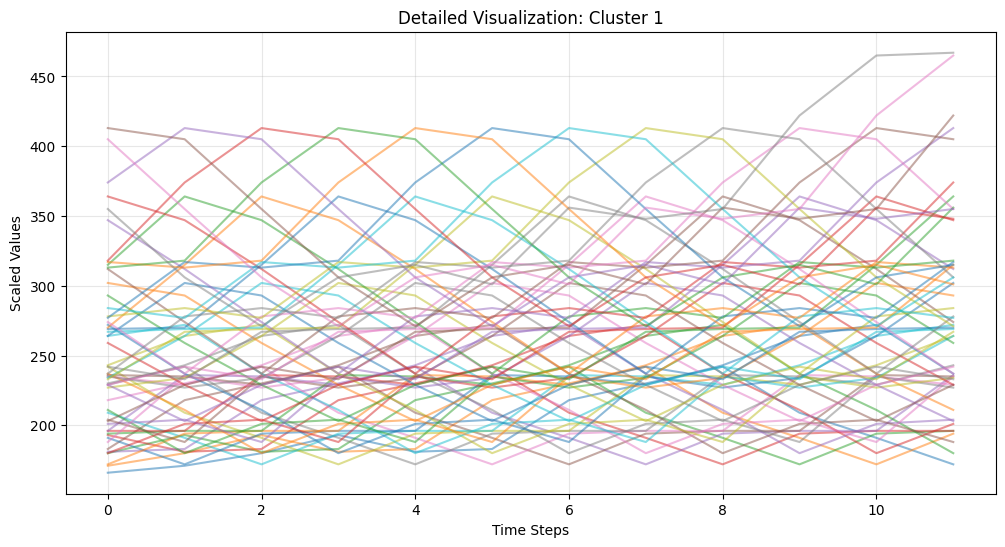

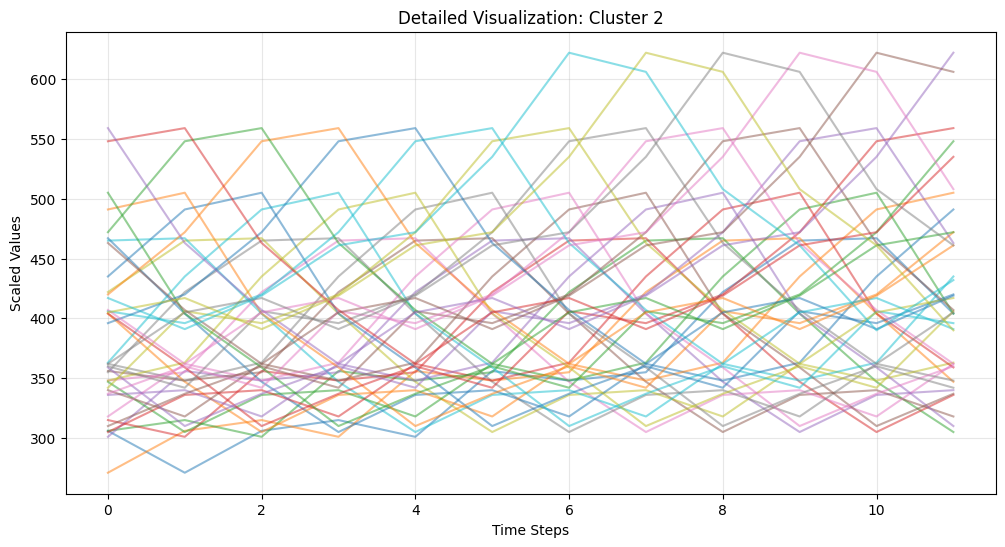

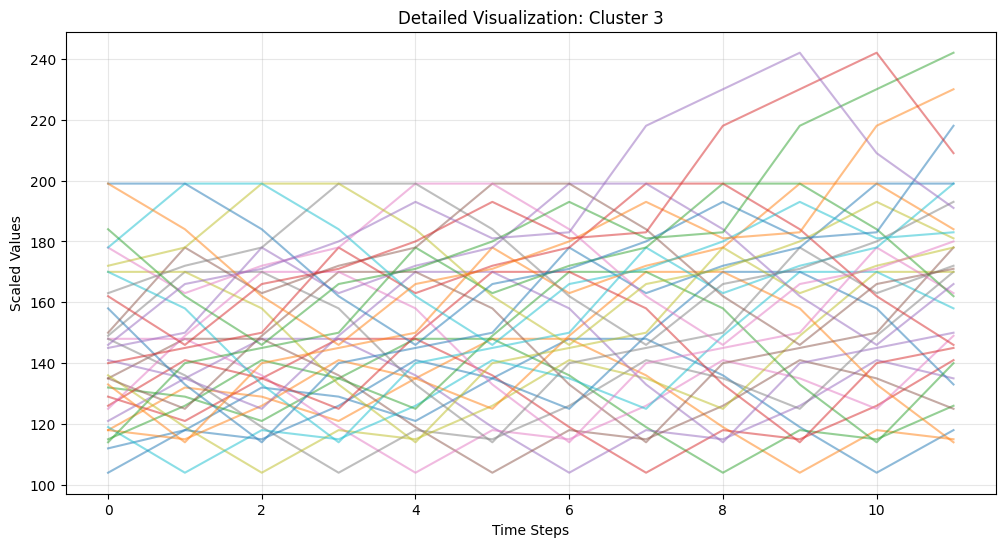

In [20]:
# Visualize time series in each cluster with intra-cluster similarity
def detailed_cluster_visualization(windows, labels, n_clusters):
    """Show intra-cluster similarity by plotting all series in each cluster."""
    for cluster in range(n_clusters):
        plt.figure(figsize=(12, 6))
        cluster_windows = windows[labels == cluster]
        for series in cluster_windows:
            plt.plot(series.ravel(), alpha=0.5)
        plt.title(f"Detailed Visualization: Cluster {cluster + 1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Scaled Values")
        plt.grid(alpha=0.3)
        plt.show()

# Visualize detailed intra-cluster similarity
detailed_cluster_visualization(original_windows, cluster_labels, n_clusters)